## Online Retail dataset

This is a transnational data set which contains all the transactions occurring between **01/12/2010 and 09/12/2011** for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### Attribute Information:

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description:** Product (item) name. Nominal.

**Quantity:** The quantities of each product (item) per transaction. Numeric.

**InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.

**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.

**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country:** Country name. Nominal, the name of the country where each customer resides.

## Customer segmentation

In [301]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from prophet import Prophet
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
import datetime as dt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import squarify
from matplotlib import pylab
# Error metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

#### EDA

In [2]:
df = pd.read_excel('../data/Online_Retail.xlsx')

In [3]:
# Let's see how the dataframe looks
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
# Check type of each column in the dataframe
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
# Check if there are missing values
df.isnull().values.any()

True

In [8]:
# Missing values by column
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# Total missing values
df.isnull().sum().sum()

136534

In [10]:
# Share of missing values over the entire dataset
# Although almost 25% of data is NA, Most of them are in CutomerID column, there is no way to impute this column
# We can consider discard this NA rows
print("%.2f" % (df["CustomerID"].isnull().sum().sum()/df.shape[0]))

0.25


In [11]:
# Let's make a copy of the original dataset
df1 = df.copy()
df1["TotalPrice"] = df1["Quantity"]*df1["UnitPrice"]
df1.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34

In [12]:
# Discard NA rows
df1 = df1.dropna()

In [13]:
# CustomerID as integer
df1["CustomerID"] = df1["CustomerID"].astype("int")

In [14]:
# Identify duplicates and delete them
print('Number of duplicate entries: {}'.format(df1.duplicated().sum()))
df1.drop_duplicates(inplace = True)

Number of duplicate entries: 5225


In [15]:
# Let's see data about countries in dataset
temp = df1[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in the dataset: {}'.format(len(countries)))

Number of countries in the dataset: 37


In [16]:
# let's see the number of orders per country in a map
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Orders'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

Here we can see that our main market is in the UK. 90% of the share are from UK.

In [17]:
# Let's see the number of products, transactions and customers
pd.DataFrame([{'products': len(df1['StockCode'].value_counts()),    
               'transactions': len(df1['InvoiceNo'].value_counts()),
               'customers': len(df1['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

products  transactions  customers
quantity      3684         22190       4372

It means we have 4372 customers. They have purchased 3684 products in 22190 transactions

In [18]:
# Let's see the number of products purchased by transaction
temp = df1.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
number_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
number_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0       12346    541431                   1
1       12346   C541433                   1
2       12347    537626                  31
3       12347    542237                  29
4       12347    549222                  24
5       12347    556201                  18
6       12347    562032                  22
7       12347    573511                  47
8       12347    581180                  11
9       12348    539318                  17

In [19]:
# What are the most sold products
top_ten_products = df1.groupby('Description',as_index=False)['Quantity','TotalPrice'].sum().sort_values(by='Quantity',
                                                                                               ascending=False).head(10)
top_ten_products['AvgUnitPrice'] = top_ten_products.TotalPrice/top_ten_products.Quantity

top_ten_products

Description  Quantity  TotalPrice  AvgUnitPrice
3805   WORLD WAR 2 GLIDERS ASSTD DESIGNS     53119    13304.49      0.250466
1771             JUMBO BAG RED RETROSPOT     44963    83056.52      1.847219
217        ASSORTED COLOUR BIRD ORNAMENT     35215    56331.91      1.599657
3716  WHITE HANGING HEART T-LIGHT HOLDER     34128    93767.80      2.747533
2279     PACK OF 72 RETROSPOT CAKE CASES     33386    16235.30      0.486291
2612                      POPCORN HOLDER     30492    23088.10      0.757185
2669                  RABBIT NIGHT LIGHT     27045    51042.84      1.887330
2057             MINI PAINT SET VINTAGE      25880    15911.84      0.614832
2245          PACK OF 12 LONDON TISSUES      25305     7253.61      0.286647
2277  PACK OF 60 PINK PAISLEY CAKE CASES     24129    11555.45      0.478903

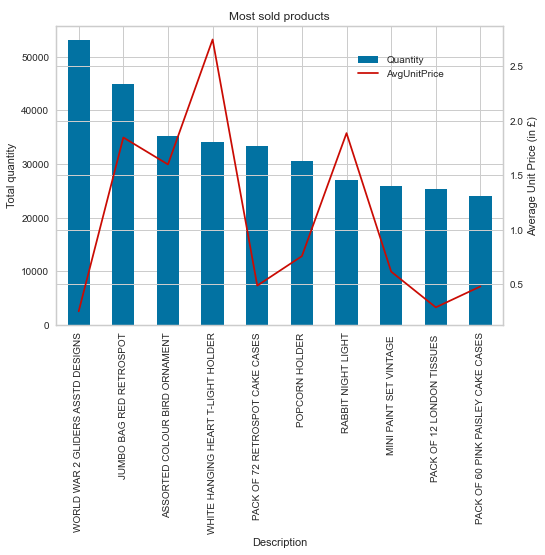

In [20]:
# Plot most sold products
ax = top_ten_products.plot(x="Description", y="Quantity", legend=False,kind='bar')
ax2 = ax.twinx()
top_ten_products.plot(x="Description", y="AvgUnitPrice", ax=ax2, legend=False, color="r")
ax.figure.legend(loc=(.65,.85))
plt.title('Most sold products')
ax.set_ylabel('Total quantity')
ax2.set_ylabel('Average Unit Price (in £)')
plt.show()

In [21]:
# What are the products with more income
top_ten_products_income = df1.groupby('Description',as_index=False)['TotalPrice','Quantity'].sum().sort_values(by='TotalPrice',
                                                                                               ascending=False).head(10)

top_ten_products_income['AvgUnitPrice'] = top_ten_products_income.TotalPrice/top_ten_products_income.Quantity
top_ten_products_income

Description  TotalPrice  Quantity  AvgUnitPrice
2780            REGENCY CAKESTAND 3 TIER   132567.70     11529     11.498630
3716  WHITE HANGING HEART T-LIGHT HOLDER    93767.80     34128      2.747533
1771             JUMBO BAG RED RETROSPOT    83056.52     44963      1.847219
2355                       PARTY BUNTING    67628.43     15015      4.504058
2624                             POSTAGE    66710.24      3002     22.221932
217        ASSORTED COLOUR BIRD ORNAMENT    56331.91     35215      1.599657
2669                  RABBIT NIGHT LIGHT    51042.84     27045      1.887330
725                        CHILLI LIGHTS    45915.41      9566      4.799855
2323     PAPER CHAIN KIT 50'S CHRISTMAS     41423.78     15138      2.736410
2405      PICNIC BASKET WICKER 60 PIECES    39619.50        61    649.500000

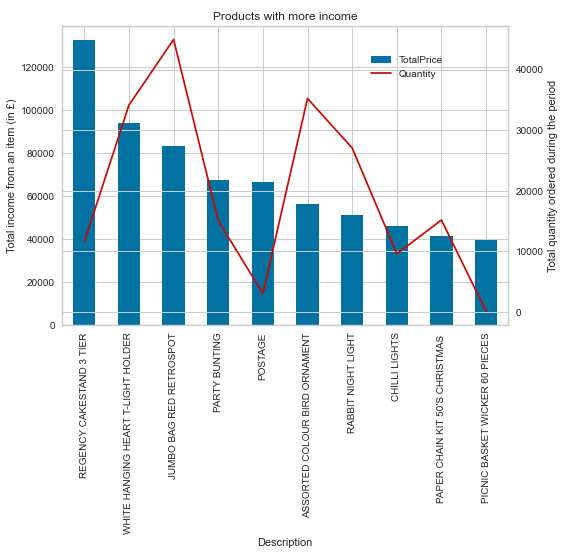

In [22]:
# Plot products with more income
ax = top_ten_products_income.plot(x="Description", y="TotalPrice", legend=False,kind='bar')
ax2 = ax.twinx()
top_ten_products_income.plot(x="Description", y="Quantity", ax=ax2, legend=False, color="r")
ax.figure.legend(loc=(.65,.85))
plt.title('Products with more income')
ax.set_ylabel('Total income from an item (in £)')
ax2.set_ylabel('Total quantity ordered during the period')
plt.show()

In [23]:
# Let's see how much money each customer spends. It is weird the customer 12346 with 0 sterling spent
df1.groupby("CustomerID").agg({"TotalPrice":"sum"}).reset_index().head()

CustomerID  TotalPrice
0       12346        0.00
1       12347     4310.00
2       12348     1797.24
3       12349     1757.55
4       12350      334.40

In [24]:
# Look there was a kind of return of this customer as there is a InvoiceNo with a cancellation
df1[df1["CustomerID"]==12346]

InvoiceNo StockCode                     Description  Quantity  \
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

              InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
61619 2011-01-18 10:01:00       1.04       12346  United Kingdom     77183.6  
61624 2011-01-18 10:17:00       1.04       12346  United Kingdom    -77183.6

In [25]:
# Number of cancellation records
df1[df1["InvoiceNo"].astype("str").str.get(0)=="C"].shape[0]

8872

In [26]:
# Take just the records that are not cancellations
df1 = df1[df1["InvoiceNo"].astype("str").str.get(0)!="C"]

In [27]:
df1.shape

(392732, 9)

In [28]:
# Let's identify atypical values based on IQR, we are going to consider values 
# less than quartile 1 and above quartile 3 as atypical
for feature in ["Quantity","UnitPrice"]:
    Q1 = df1[feature].quantile(0.01)
    Q3 = df1[feature].quantile(0.99)
    IQR = Q3-Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    
    if df1[(df1[feature] > upper) | (df1[feature] < lower)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature,"no")
        
    df1 = df1[~((df1[feature] > upper) | (df1[feature] < lower))]

Quantity yes
UnitPrice yes


In [29]:
df1.shape

(391110, 9)

In [30]:
# What are the customers with most transactions and avg per transaction
top_ten_customers = df1.groupby("CustomerID").agg({"TotalPrice":"sum",
                                                   "InvoiceNo": lambda x: x.nunique()}).reset_index().sort_values(by='InvoiceNo',
                                                                                                                  ascending=False).head(10)
top_ten_customers.rename(columns={'InvoiceNo':'Transactions'}, inplace=True)
top_ten_customers['AvgTransactionPrice'] = top_ten_customers.TotalPrice/top_ten_customers.Transactions
top_ten_customers

CustomerID  TotalPrice  Transactions  AvgTransactionPrice
325        12748    31244.49           207           150.939565
1874       14911   135029.23           198           681.965808
3991       17841    39760.79           124           320.651532
560        13089    58642.23            96           610.856562
1657       14606    11911.25            93           128.077957
2169       15311    60632.75            91           666.293956
479        12971    10739.91            86           124.882674
1684       14646   250146.06            70          3573.515143
792        13408    28117.04            62           453.500645
2690       16029    46540.25            60           775.670833

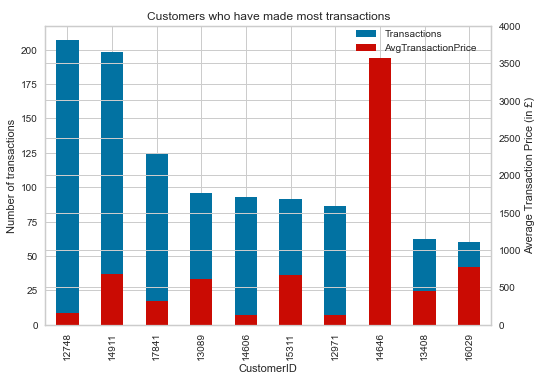

In [32]:
# Plot customers who have made most transactions
ax = top_ten_customers.plot(x="CustomerID", y="Transactions", legend=False,kind='bar')
ax2 = ax.twinx()
ax2.set_ylim([0,4000])
top_ten_customers.plot(x="CustomerID", y="AvgTransactionPrice", ax=ax2, legend=False, kind='bar',color="r")
ax.figure.legend(loc=(.65,.85))
plt.title('Customers who have made most transactions')
ax.set_ylabel('Number of transactions')
ax2.set_ylabel('Average Transaction Price (in £)')
plt.show()

In [33]:
# What are the customers with most transactions and avg per transaction
top_ten_customers_income = df1.groupby("CustomerID").agg({"TotalPrice":"sum",
                                                          "InvoiceNo": lambda x: x.nunique()}).reset_index().sort_values(by='TotalPrice',
                                                                                                                         ascending=False).head(10)
top_ten_customers_income.rename(columns={'InvoiceNo':'Transactions'}, inplace=True)
top_ten_customers_income['AvgTransactionPrice'] = top_ten_customers_income.TotalPrice/top_ten_customers_income.Transactions
top_ten_customers_income

CustomerID  TotalPrice  Transactions  AvgTransactionPrice
1684       14646   250146.06            70          3573.515143
1874       14911   135029.23           198           681.965808
4178       18102   133887.82            55          2434.324000
54         12415   113424.21            20          5671.210500
1329       14156   111261.28            54          2060.394074
3753       17511    89570.18            31          2889.360645
3710       17450    70970.07            40          1774.251750
992        13694    62068.65            49          1266.707143
2169       15311    60632.75            91           666.293956
560        13089    58642.23            96           610.856562

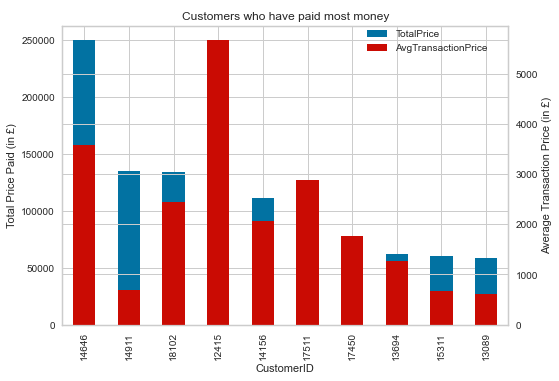

In [35]:
# Plot customers who have paid most money
ax = top_ten_customers_income.plot(x="CustomerID", y="TotalPrice", legend=False,kind='bar')
ax2 = ax.twinx()
top_ten_customers_income.plot(x="CustomerID", y="AvgTransactionPrice", ax=ax2, legend=False, kind='bar',color="r")
ax.figure.legend(loc=(.65,.85))
plt.title('Customers who have paid most money')
ax.set_ylabel('Total Price Paid (in £)')
ax2.set_ylabel('Average Transaction Price (in £)')
plt.show()

In [36]:
# Let's see the max date
df1["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

#### Recency

In [37]:
today_date = dt.datetime(2011,12,10)
today_date

datetime.datetime(2011, 12, 10, 0, 0)

In [38]:
# Estimate the number of days since the last purchase
recency = today_date - df1.groupby("CustomerID").agg({"InvoiceDate":"max"})
recency.reset_index().head()

CustomerID       InvoiceDate
0       12347   2 days 08:08:00
1       12348  75 days 10:47:00
2       12349  18 days 14:09:00
3       12350 310 days 07:59:00
4       12352  36 days 09:23:00

In [39]:
# Take just the number of days since the last purchase
recency["InvoiceDate"] = recency["InvoiceDate"].apply(lambda x:x.days)
recency.reset_index().head()

CustomerID  InvoiceDate
0       12347            2
1       12348           75
2       12349           18
3       12350          310
4       12352           36

In [40]:
recency.rename(columns={"InvoiceDate":"Recency"}, inplace=True)
recency.reset_index().head()

CustomerID  Recency
0       12347        2
1       12348       75
2       12349       18
3       12350      310
4       12352       36

#### Frequency

In [41]:
# Number of transactions by customer
df1.groupby("CustomerID").agg({"InvoiceNo":"nunique"}).reset_index().head()

CustomerID  InvoiceNo
0       12347          7
1       12348          4
2       12349          1
3       12350          1
4       12352          7

In [42]:
# Let's compute the frequency, number of transactions made by customer
frequency = df1.groupby("CustomerID").agg({"InvoiceDate":"nunique"}).rename(columns={"InvoiceDate":"Frequency"})
frequency.reset_index().head()

CustomerID  Frequency
0       12347          7
1       12348          4
2       12349          1
3       12350          1
4       12352          7

#### Monetary

In [43]:
# Amount spent by customer
monetary = df1.groupby("CustomerID").agg({"TotalPrice":"sum"}).rename(columns={"TotalPrice":"Monetary"})
monetary.reset_index().head()

CustomerID  Monetary
0       12347   4310.00
1       12348   1437.24
2       12349   1417.60
3       12350    294.40
4       12352   1385.74

In [44]:
# Let's check the shape of each component
print(recency.shape, frequency.shape, monetary.shape)

(4313, 1) (4313, 1) (4313, 1)


In [45]:
# Concat RFM components and make a copy for k means approach
rfm = pd.concat([recency,frequency,monetary], axis=1)
rfm_kmeans = rfm.copy()
rfm.reset_index().head()

CustomerID  Recency  Frequency  Monetary
0       12347        2          7   4310.00
1       12348       75          4   1437.24
2       12349       18          1   1417.60
3       12350      310          1    294.40
4       12352       36          7   1385.74

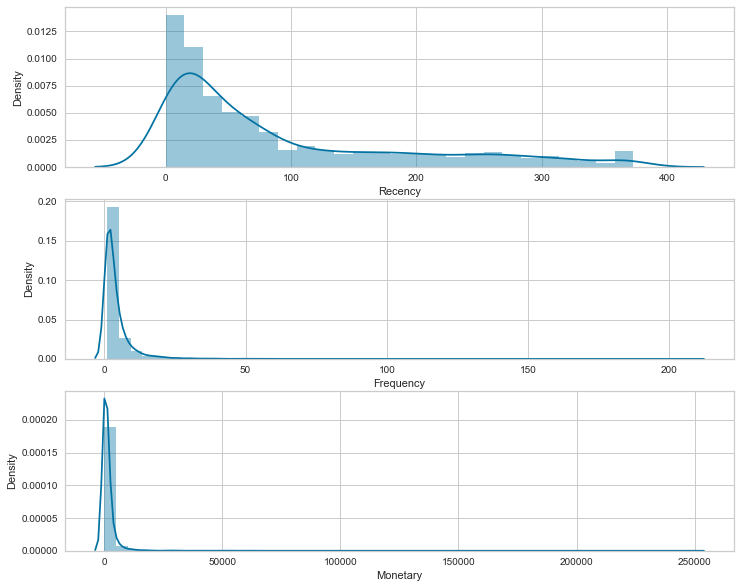

In [46]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'])
# Show the plot
plt.show()

Here we can see how skewed is the data

In [47]:
# RFM Score, based on the quintiles
rfm["Recency_Score"] = pd.qcut(rfm["Recency"],5, labels=[5,4,3,2,1])
rfm["Frequency_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["Monetary_Score"] = pd.qcut(rfm["Monetary"],5, labels=[1,2,3,4,5])
rfm.reset_index().head()

CustomerID  Recency  Frequency  Monetary Recency_Score Frequency_Score  \
0       12347        2          7   4310.00             5               5   
1       12348       75          4   1437.24             2               4   
2       12349       18          1   1417.60             4               1   
3       12350      310          1    294.40             1               1   
4       12352       36          7   1385.74             3               5   

  Monetary_Score  
0              5  
1              4  
2              4  
3              2  
4              4

In [48]:
rfm["RFM"] = rfm["Recency_Score"].astype(str)+rfm["Frequency_Score"].astype(str)+rfm["Monetary_Score"].astype(str)
rfm.reset_index().head()

CustomerID  Recency  Frequency  Monetary Recency_Score Frequency_Score  \
0       12347        2          7   4310.00             5               5   
1       12348       75          4   1437.24             2               4   
2       12349       18          1   1417.60             4               1   
3       12350      310          1    294.40             1               1   
4       12352       36          7   1385.74             3               5   

  Monetary_Score  RFM  
0              5  555  
1              4  244  
2              4  414  
3              2  112  
4              4  354

In [49]:
# Create a dictionary aimed to segment based on RFM
segmentation_map = {r'[1-2][1-2]': "Hibernating",
                    r'[1-2][3-4]': "At Risk", 
                    r'[1-2]5': "Can't Lose", 
                    r'3[1-2]': "About to Sleep",
                    r'33': "Need Attention", 
                    r'[3-4][4-5]': "Loyal Customers", 
                    r'41': "Promising", 
                    r'51': "New Customers",
                    r'[4-5][2-3]': "Potential Loyalist", 
                    r'5[4-5]': "Champions"}

#### **Segment definition**
**Hibernating:** Customers who have purchased more than two months ago and with low frequency (1 to 2 times).

**At risk:** Customers who have purchased more than two months ago but with a medium frequency (2 to 5 times).

**Can't Lose:** Customers who have purchased more than two months ago but with a high frequency (5 to 33 times).

**About to sleep:** Customers who have purchased one or two months ago but with low frequency (1 to 2 times).

**Need attention:** Customers who have purchased one or two months ago but with medium frequency (2 to 3 times).

**Loyal Customers:** Customers who have purchased two weeks to two months ago but with high frequency (3 to 58 times).

**Promising:** Customers who have purchased two weeks to a month ago with low frequency (1 time).

**New customers:** Customers who have purchased less than two weeks ago one time.

**Potential Loyalist:** Customers who have purchased less than a month ago with medium frequency (1 to 3 times).

**Champions:** Customers who have purchased less than two weeks and with  high frequency (3 to 208  times).

In [50]:
rfm["Segment"] = rfm["Recency_Score"].astype(str)+ rfm["Frequency_Score"].astype(str)
rfm["Segment"] = rfm["Segment"].replace(segmentation_map,regex=True)
rfm.reset_index().head(25)

CustomerID  Recency  Frequency  Monetary Recency_Score Frequency_Score  \
0        12347        2          7   4310.00             5               5   
1        12348       75          4   1437.24             2               4   
2        12349       18          1   1417.60             4               1   
3        12350      310          1    294.40             1               1   
4        12352       36          7   1385.74             3               5   
5        12353      204          1     89.00             1               1   
6        12354      232          1   1079.40             1               1   
7        12355      214          1    459.40             1               1   
8        12356       22          3   2811.43             4               3   
9        12357       33          1   6207.67             3               1   
10       12358        1          2    928.06             5               2   
11       12359       57          4   4980.13             3               4   
12       12360       52          3   2302.06             3               3   
13       12361      287          1    189.90             1               1   
14       12362        3         10   5226.23             5               5   
15       12363      109          2    552.00             2               2   
16       12364        7          4   1313.10             5               4   
17       12365      291          1    320.69             1               1   
18       12367        4          1    168.90             5               1   
19       12370       51          4   3421.94             3               4   
20       12371       59          1   1527.96             3               1   
21       12372       71          3   1298.04             3               3   
22       12373      311          1    324.60             1               1   
23       12374       25          1    622.93             4               1   
24       12375       10          2    377.50             5               2   

   Monetary_Score  RFM             Segment  
0               5  555           Champions  
1               4  244             At Risk  
2               4  414           Promising  
3               2  112         Hibernating  
4               4  354     Loyal Customers  
5               1  111         Hibernating  
6               4  114         Hibernating  
7               2  112         Hibernating  
8               5  435  Potential Loyalist  
9               5  315      About to Sleep  
10              4  524  Potential Loyalist  
11              5  345     Loyal Customers  
12              5  335      Need Attention  
13              1  111         Hibernating  
14              5  555           Champions  
15              3  223         Hibernating  
16              4  544           Champions  
17              2  112         Hibernating  
18              1  511       New Customers  
19              5  345     Loyal Customers  
20              4  314      About to Sleep  
21              4  334      Need Attention  
22              2  112         Hibernating  
23              3  413           Promising  
24              2  522  Potential Loyalist

In [51]:
rfm[["Segment","Recency","Frequency","Monetary"]].groupby("Segment").agg(["min","max","mean","count"])

Recency                        Frequency                  \
                       min  max        mean count       min  max       mean   
Segment                                                                       
About to Sleep          33   71   52.415473   349         1    2   1.143266   
At Risk                 72  373  153.217094   585         2    5   2.839316   
Can't Lose              72  372  133.753846    65         5   33   8.184615   
Champions                0   12    5.390127   628         3  208  12.191083   
Hibernating             72  373  216.606573  1065         1    2   1.092958   
Loyal Customers         14   71   32.740514   817         3   58   6.407589   
Need Attention          33   71   51.220430   186         2    3   2.306452   
New Customers            0   12    6.425000    40         1    1   1.000000   
Potential Loyalist       0   32   16.382716   486         1    3   1.993827   
Promising               14   32   22.489130    92         1    1   1.000000   

                         Monetary                                
                   count      min        max         mean count  
Segment                                                          
About to Sleep       349     6.20    6207.67   472.688711   349  
At Risk              585    52.00   11072.67   904.352909   585  
Can't Lose            65    70.02   10254.18  2569.865231    65  
Champions            628    20.92  250146.06  6003.634745   628  
Hibernating         1065     2.90    8951.26   389.018377  1065  
Loyal Customers      817    36.56  113424.21  2668.803539   817  
Need Attention       186     6.90    3683.86   826.781505   186  
New Customers         40    89.94     848.55   290.338500    40  
Potential Loyalist   486    20.80    4628.75   654.171687   486  
Promising             92    30.00    1417.60   277.384891    92

In [52]:
# Calculate average values for each segment, and return a size of each segment 
rfm_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
    }).round(1)
# Print the aggregated dataset
rfm_summary

Recency Frequency Monetary      
                      mean      mean     mean count
Segment                                            
About to Sleep        52.4       1.1    472.7   349
At Risk              153.2       2.8    904.4   585
Can't Lose           133.8       8.2   2569.9    65
Champions              5.4      12.2   6003.6   628
Hibernating          216.6       1.1    389.0  1065
Loyal Customers       32.7       6.4   2668.8   817
Need Attention        51.2       2.3    826.8   186
New Customers          6.4       1.0    290.3    40
Potential Loyalist    16.4       2.0    654.2   486
Promising             22.5       1.0    277.4    92

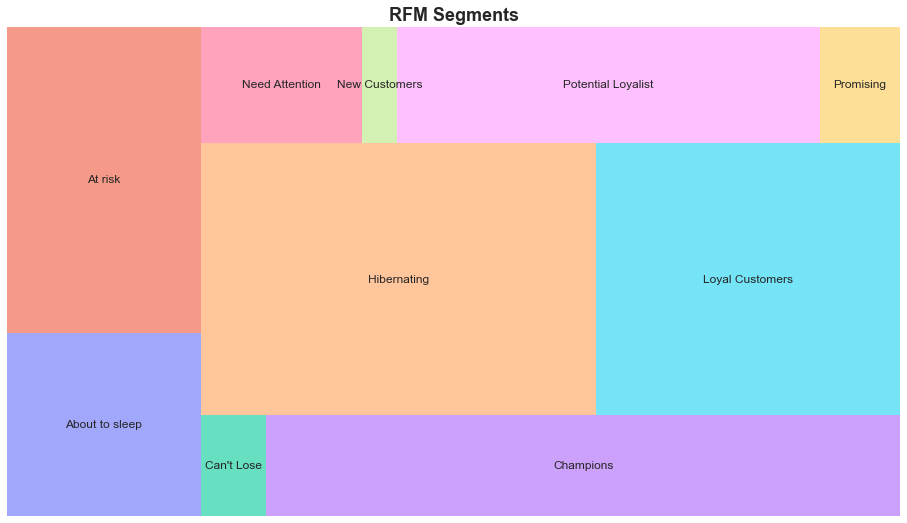

In [53]:
rfm_summary.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_summary['Count'], 
              label=['About to sleep',
                     'At risk',
                     'Can\'t Lose',
                     'Champions',
                     'Hibernating',
                     'Loyal Customers',
                     'Need Attention', 
                     'New Customers', 
                     'Potential Loyalist',
                     'Promising'
                    ], 
              color=['#636EFA','#EF553B','#00CC96','#AB63FA','#FFA15A',
                     '#19D3F3','#FF6692','#B6E880','#FF97FF','#FECB52'],
              alpha=.6 )

plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

### K means approach

In [54]:
rfm_kmeans.head(10)

Recency  Frequency  Monetary
CustomerID                              
12347             2          7   4310.00
12348            75          4   1437.24
12349            18          1   1417.60
12350           310          1    294.40
12352            36          7   1385.74
12353           204          1     89.00
12354           232          1   1079.40
12355           214          1    459.40
12356            22          3   2811.43
12357            33          1   6207.67

In [55]:
# Data preparation
sc = MinMaxScaler((0, 1))
rfm_kmeans = sc.fit_transform(rfm_kmeans)
rfm_kmeans[0:5]

array([[0.00536193, 0.02898551, 0.01721854],
       [0.20107239, 0.01449275, 0.00573408],
       [0.04825737, 0.        , 0.00565556],
       [0.8310992 , 0.        , 0.00116533],
       [0.09651475, 0.02898551, 0.00552819]])

In [56]:
# K-MEANS
kmeans = KMeans(n_clusters=10)
k_fit = kmeans.fit(rfm_kmeans)
k_fit

KMeans(n_clusters=10)

In [57]:
k_fit.n_clusters

10

In [58]:
k_fit.cluster_centers_

array([[0.45831466, 0.00518333, 0.00234742],
       [0.08674052, 0.01267703, 0.00526899],
       [0.77047959, 0.0017445 , 0.00163807],
       [0.17915282, 0.00798068, 0.00416151],
       [0.61219745, 0.00255059, 0.00197337],
       [0.95037097, 0.0014886 , 0.00133755],
       [0.02563718, 0.02251852, 0.00818051],
       [0.01697945, 0.13030422, 0.06649523],
       [0.30738071, 0.00718038, 0.00333764],
       [0.00469169, 0.53019324, 0.41005591]])

In [59]:
k_fit.labels_

array([6, 3, 6, ..., 6, 6, 1])

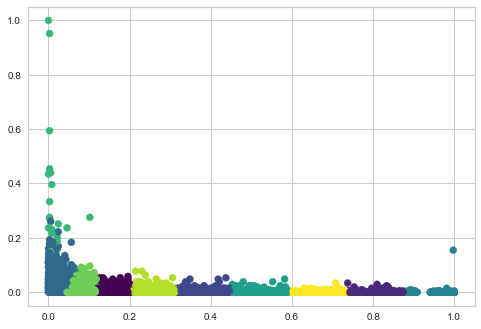

In [60]:
# Clusters visualization
k_means = KMeans(n_clusters=10).fit(rfm_kmeans)
labels = k_means.labels_
type(rfm_kmeans)
rfm_kmeans = pd.DataFrame(rfm_kmeans)

plt.scatter(rfm_kmeans.iloc[:, 0],
            rfm_kmeans.iloc[:, 1],
            c=labels,
            s=50,
            cmap="viridis")
plt.show()

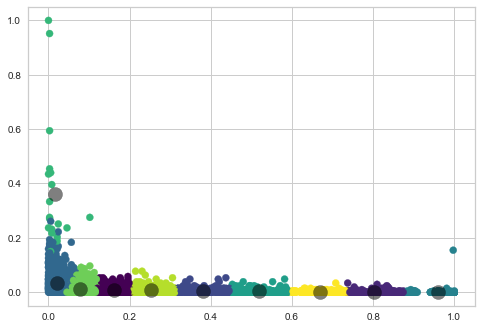

In [61]:
# Plot centers of each cluster
centers = k_means.cluster_centers_

plt.scatter(rfm_kmeans.iloc[:, 0],
            rfm_kmeans.iloc[:, 1],
            c=labels,
            s=50,
            cmap="viridis")

plt.scatter(centers[:, 0],
            centers[:, 1],
            c="black",
            s=200,
            alpha=0.5)
plt.show()

In [62]:
kmeans = KMeans(n_clusters=10).fit(rfm_kmeans)
labels = kmeans.labels_

In [63]:
rfm["cluster_number"] = labels

In [64]:
rfm["cluster_number"] = rfm["cluster_number"] + 1

In [65]:
rfm.head(20)

Recency  Frequency  Monetary Recency_Score Frequency_Score  \
CustomerID                                                               
12347             2          7   4310.00             5               5   
12348            75          4   1437.24             2               4   
12349            18          1   1417.60             4               1   
12350           310          1    294.40             1               1   
12352            36          7   1385.74             3               5   
12353           204          1     89.00             1               1   
12354           232          1   1079.40             1               1   
12355           214          1    459.40             1               1   
12356            22          3   2811.43             4               3   
12357            33          1   6207.67             3               1   
12358             1          2    928.06             5               2   
12359            57          4   4980.13             3               4   
12360            52          3   2302.06             3               3   
12361           287          1    189.90             1               1   
12362             3         10   5226.23             5               5   
12363           109          2    552.00             2               2   
12364             7          4   1313.10             5               4   
12365           291          1    320.69             1               1   
12367             4          1    168.90             5               1   
12370            51          4   3421.94             3               4   

           Monetary_Score  RFM             Segment  cluster_number  
CustomerID                                                          
12347                   5  555           Champions               1  
12348                   4  244             At Risk               4  
12349                   4  414           Promising               1  
12350                   2  112         Hibernating               3  
12352                   4  354     Loyal Customers               5  
12353                   1  111         Hibernating               2  
12354                   4  114         Hibernating               6  
12355                   2  112         Hibernating               6  
12356                   5  435  Potential Loyalist               5  
12357                   5  315      About to Sleep               5  
12358                   4  524  Potential Loyalist               1  
12359                   5  345     Loyal Customers               4  
12360                   5  335      Need Attention               4  
12361                   1  111         Hibernating               3  
12362                   5  555           Champions               1  
12363                   3  223         Hibernating               8  
12364                   4  544           Champions               1  
12365                   2  112         Hibernating               3  
12367                   1  511       New Customers               1  
12370                   5  345     Loyal Customers               4

In [66]:
# Determine the optimal number of clusters
kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(rfm_kmeans)
    ssd.append(kmeans.inertia_)

In [67]:
ssd

[318.7605459025912,
 72.24320388994568,
 38.86239647031584,
 25.52495514354931,
 18.90985823475129,
 15.12315712509611,
 11.819561153665816,
 9.935003194580375,
 8.577373148206275,
 7.515555935788715,
 6.472398086836444,
 5.647280848662367,
 4.942999630945884,
 4.414229425674762,
 3.9240847367204235,
 3.5577735744035732,
 3.2696203650765665,
 2.9686534677040917,
 2.7327840009083912,
 2.5499914305212683,
 2.3696114509722093,
 2.2323220847794976,
 2.0654627660163283,
 1.95695766747118,
 1.8636059788839834,
 1.775082516052913,
 1.6416389462532002,
 1.5554949513399345,
 1.4990752342677105]

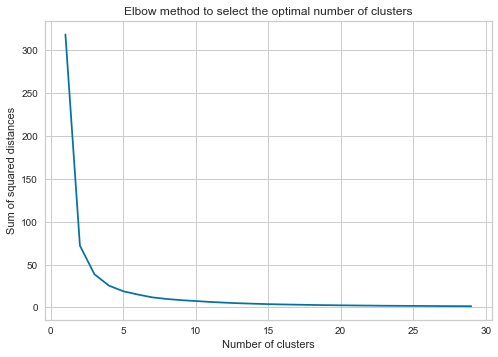

In [68]:
plt.plot(K, ssd, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.title("Elbow method to select the optimal number of clusters")
plt.show()

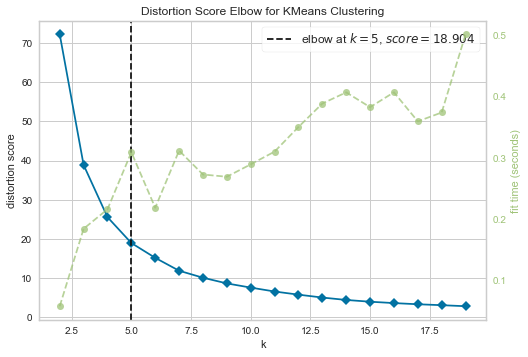

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
# Another way more automated
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(rfm_kmeans)
visu.show()

In [70]:
kmeans = KMeans(n_clusters=5).fit(rfm_kmeans)
labels = kmeans.labels_

In [71]:
rfm["cluster_number"] = labels

In [72]:
rfm.head()

Recency  Frequency  Monetary Recency_Score Frequency_Score  \
CustomerID                                                               
12347             2          7   4310.00             5               5   
12348            75          4   1437.24             2               4   
12349            18          1   1417.60             4               1   
12350           310          1    294.40             1               1   
12352            36          7   1385.74             3               5   

           Monetary_Score  RFM          Segment  cluster_number  
CustomerID                                                       
12347                   5  555        Champions               0  
12348                   4  244          At Risk               3  
12349                   4  414        Promising               0  
12350                   2  112      Hibernating               2  
12352                   4  354  Loyal Customers               0

In [73]:
rfm["cluster_number"] = rfm["cluster_number"] + 1

In [74]:
rfm.head(20)

Recency  Frequency  Monetary Recency_Score Frequency_Score  \
CustomerID                                                               
12347             2          7   4310.00             5               5   
12348            75          4   1437.24             2               4   
12349            18          1   1417.60             4               1   
12350           310          1    294.40             1               1   
12352            36          7   1385.74             3               5   
12353           204          1     89.00             1               1   
12354           232          1   1079.40             1               1   
12355           214          1    459.40             1               1   
12356            22          3   2811.43             4               3   
12357            33          1   6207.67             3               1   
12358             1          2    928.06             5               2   
12359            57          4   4980.13             3               4   
12360            52          3   2302.06             3               3   
12361           287          1    189.90             1               1   
12362             3         10   5226.23             5               5   
12363           109          2    552.00             2               2   
12364             7          4   1313.10             5               4   
12365           291          1    320.69             1               1   
12367             4          1    168.90             5               1   
12370            51          4   3421.94             3               4   

           Monetary_Score  RFM             Segment  cluster_number  
CustomerID                                                          
12347                   5  555           Champions               1  
12348                   4  244             At Risk               4  
12349                   4  414           Promising               1  
12350                   2  112         Hibernating               3  
12352                   4  354     Loyal Customers               1  
12353                   1  111         Hibernating               5  
12354                   4  114         Hibernating               5  
12355                   2  112         Hibernating               5  
12356                   5  435  Potential Loyalist               1  
12357                   5  315      About to Sleep               1  
12358                   4  524  Potential Loyalist               1  
12359                   5  345     Loyal Customers               4  
12360                   5  335      Need Attention               4  
12361                   1  111         Hibernating               5  
12362                   5  555           Champions               1  
12363                   3  223         Hibernating               4  
12364                   4  544           Champions               1  
12365                   2  112         Hibernating               5  
12367                   1  511       New Customers               1  
12370                   5  345     Loyal Customers               4

In [77]:
rfm.groupby("cluster_number").agg({"cluster_number": "count",
                                   "Recency":"mean",
                                   "Frequency":"mean",
                                   "Monetary":"mean"
                                  })

cluster_number     Recency  Frequency     Monetary
cluster_number                                                    
1                         2015   17.347891   6.572208  2988.461921
2                          518  157.681467   2.108108   646.634595
3                          288  335.666667   1.357639   375.570938
4                         1050   71.213333   2.679048  1015.417659
5                          442  246.997738   1.443439   461.169731

In [78]:
rfm[["cluster_number","Recency","Frequency","Monetary"]].groupby("cluster_number").agg(["min","max","mean","count"])

Recency                        Frequency                       \
                   min  max        mean count       min  max      mean count   
cluster_number                                                                 
1                    0   45   17.347891  2015         1  208  6.572208  2015   
2                  115  201  157.681467   518         1   12  2.108108   518   
3                  292  373  335.666667   288         1   33  1.357639   288   
4                   44  114   71.213333  1050         1   17  2.679048  1050   
5                  203  291  246.997738   442         1   11  1.443439   442   

               Monetary                                
                    min        max         mean count  
cluster_number                                         
1                 20.80  250146.06  2988.461921  2015  
2                 15.00    7374.90   646.634595   518  
3                  3.75    5391.21   375.570938   288  
4                  6.20   11072.67  1015.417659  1050  
5                  2.90    8951.26   461.169731   442

The segmentation we got through RFM method was better than the one we got from K means. Here we have little detail about each cluster.

## Forecasting problems

In [116]:
df2 = df1.copy()

In [117]:
df2['date'] = pd.to_datetime(df1['InvoiceDate']).dt.date

In [120]:
df2['weekday'] = pd.to_datetime(df2['date']).dt.dayofweek
df2.tail()

InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID Country  TotalPrice  \
541904 2011-12-09 12:50:00       0.85       12680  France       10.20   
541905 2011-12-09 12:50:00       2.10       12680  France       12.60   
541906 2011-12-09 12:50:00       4.15       12680  France       16.60   
541907 2011-12-09 12:50:00       4.15       12680  France       16.60   
541908 2011-12-09 12:50:00       4.95       12680  France       14.85   

              date  weekday  
541904  2011-12-09        4  
541905  2011-12-09        4  
541906  2011-12-09        4  
541907  2011-12-09        4  
541908  2011-12-09        4

### Let's see sales per day and month

In [219]:
sales_per_day = df2.groupby('date').agg({'TotalPrice':'sum'}).reset_index()
sales_per_day

date  TotalPrice
0    2010-12-01    41907.09
1    2010-12-02    43179.02
2    2010-12-03    23566.23
3    2010-12-05    31024.33
4    2010-12-06    28574.73
..          ...         ...
300  2011-12-05    52295.99
301  2011-12-06    45854.66
302  2011-12-07    50933.20
303  2011-12-08    40294.06
304  2011-12-09    15860.06

[305 rows x 2 columns]

In [122]:
px.line(sales_per_day, x = sales_per_day.date, y = sales_per_day.TotalPrice)

In [126]:
fig = px.line(sales_per_day, x = sales_per_day.date, y = sales_per_day.TotalPrice)
fig.add_vline(x='2010-12-05', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2010-12-12', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2010-12-19', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2010-12-26', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-02', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-09', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-16', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-23', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-30', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-06', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-13', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-20', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-27', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-06', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-13', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-20', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-27', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-03', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-10', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-17', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-24', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-01', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-08', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-15', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-22', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-29', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-05', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-12', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-19', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-26', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-03', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-10', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-17', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-24', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-31', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-07', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-14', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-21', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-28', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-04', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-11', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-18', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-25', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-02', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-09', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-16', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-23', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-30', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-06', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-13', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-20', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-27', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-12-04', line_width=2, line_dash="dash", line_color="red")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Here we can see in red dashed lines each week, so that we could identify a visible pattern.

In [125]:
df2.groupby('weekday').agg({'TotalPrice':'sum'}).reset_index()

weekday   TotalPrice
0        0  1235894.571
1        1  1383885.751
2        2  1460592.970
3        3  1724959.370
4        4  1159759.201
5        6   769805.621

There is no sales on Saturdays in the dataset

In [131]:
df2['year_month'] = pd.to_datetime(df2['date']).dt.to_period('M')
df2.tail()

InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID Country  TotalPrice  \
541904 2011-12-09 12:50:00       0.85       12680  France       10.20   
541905 2011-12-09 12:50:00       2.10       12680  France       12.60   
541906 2011-12-09 12:50:00       4.15       12680  France       16.60   
541907 2011-12-09 12:50:00       4.15       12680  France       16.60   
541908 2011-12-09 12:50:00       4.95       12680  France       14.85   

              date  weekday year_month  
541904  2011-12-09        4    2011-12  
541905  2011-12-09        4    2011-12  
541906  2011-12-09        4    2011-12  
541907  2011-12-09        4    2011-12  
541908  2011-12-09        4    2011-12

In [132]:
sales_per_month = df2.groupby('year_month').agg({'TotalPrice':'sum'}).reset_index()
sales_per_month

year_month   TotalPrice
0     2010-12   513451.610
1     2011-01   435340.660
2     2011-02   413080.200
3     2011-03   538510.500
4     2011-04   406473.301
5     2011-05   622224.300
6     2011-06   554325.930
7     2011-07   548351.151
8     2011-08   574359.750
9     2011-09   825910.222
10    2011-10   916375.730
11    2011-11  1079834.420
12    2011-12   306659.710

In [134]:
fig = go.Figure(data=go.Scatter(x=sales_per_month['year_month'].astype(dtype=str), 
                        y=sales_per_month['TotalPrice'],
                        marker_color='indianred', text="TotalPrice"))
fig.update_layout({"title": 'Sales from Dec 2010 to Dec 2011',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total income (in £)"},
                   "showlegend": False})
fig.show()

The sales has increased significantly since July, 2011.

### Let's see the number of transactions per day and month

In [138]:
transactions_per_day = df2.groupby('date').agg({'InvoiceNo':'nunique'}).reset_index()
transactions_per_day.rename(columns={'InvoiceNo':'Transactions'}, inplace=True)
transactions_per_day

date  Transactions
0    2010-12-01           120
1    2010-12-02           134
2    2010-12-03            57
3    2010-12-05            87
4    2010-12-06            94
..          ...           ...
300  2011-12-05           114
301  2011-12-06           110
302  2011-12-07           100
303  2011-12-08           111
304  2011-12-09            40

[305 rows x 2 columns]

In [139]:
px.line(transactions_per_day, x = transactions_per_day.date, y = transactions_per_day.Transactions)

In [140]:
fig = px.line(transactions_per_day, x = transactions_per_day.date, y = transactions_per_day.Transactions)
fig.add_vline(x='2010-12-05', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2010-12-12', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2010-12-19', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2010-12-26', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-02', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-09', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-16', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-23', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-01-30', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-06', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-13', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-20', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-02-27', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-06', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-13', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-20', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-03-27', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-03', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-10', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-17', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-04-24', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-01', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-08', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-15', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-22', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-05-29', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-05', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-12', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-19', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-06-26', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-03', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-10', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-17', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-24', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-07-31', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-07', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-14', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-21', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-08-28', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-04', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-11', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-18', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-09-25', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-02', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-09', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-16', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-23', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-10-30', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-06', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-13', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-20', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-11-27', line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x='2011-12-04', line_width=2, line_dash="dash", line_color="red")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [141]:
transactions_per_month = df2.groupby('year_month').agg({'InvoiceNo':'nunique'}).reset_index()
transactions_per_month.rename(columns={'InvoiceNo':'Transactions'}, inplace=True)
transactions_per_month

year_month  Transactions
0     2010-12          1384
1     2011-01           973
2     2011-02           983
3     2011-03          1302
4     2011-04          1125
5     2011-05          1527
6     2011-06          1373
7     2011-07          1316
8     2011-08          1260
9     2011-09          1735
10    2011-10          1898
11    2011-11          2626
12    2011-12           765

In [143]:
fig = go.Figure(data=go.Scatter(x=transactions_per_month['year_month'].astype(dtype=str), 
                        y=transactions_per_month['Transactions'],
                        marker_color='indianred', text="Transactions"))
fig.update_layout({"title": 'Transactions from Dec 2010 to Dec 2011',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Number of transactions"},
                   "showlegend": False})
fig.show()

As we can see this time series is very similar to sales time series, it shows the same trend

### Let's start with modeling

In [220]:
# Set date_partition as datetime 
sales_per_day['date'] = pd.to_datetime(sales_per_day.date)

In [221]:
sales_per_day.set_index('date',inplace=True)

In [222]:
# Set the frequency of the date time index as daily start as indicated by the data
sales_per_day.index.to_period('D')

PeriodIndex(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-05',
             '2010-12-06', '2010-12-07', '2010-12-08', '2010-12-09',
             '2010-12-10', '2010-12-12',
             ...
             '2011-11-29', '2011-11-30', '2011-12-01', '2011-12-02',
             '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
             '2011-12-08', '2011-12-09'],
            dtype='period[D]', name='date', length=305)

In [252]:
# Split into train and test set
train_daily_sales = sales_per_day[(sales_per_day.index >= '2010-12-01') & (sales_per_day.index <= '2011-10-31')]
test_daily_sales = sales_per_day[(sales_per_day.index >= '2011-11-01') & (sales_per_day.index <= '2011-12-09')]

In [253]:
train_daily_sales = train_daily_sales[['TotalPrice']]
test_daily_sales = test_daily_sales[['TotalPrice']]

In [261]:
# Save the index so that after prediction you could joint it
test_index = test_daily_sales.reset_index()[['date']]

In [272]:
winters_daily_sales_model = ExponentialSmoothing(train_daily_sales['TotalPrice'],
                                                 trend='mul',
                                                 seasonal='mul',
                                                 seasonal_periods=7).fit()

In [273]:
# Set the number of days you want to forecast with the trained model
winters_daily_sales_predictions = winters_daily_sales_model.forecast(34)

In [274]:
winters_daily_sales_predictions = pd.DataFrame(winters_daily_sales_predictions,columns = ['TotalPrice'])
winters_daily_sales_predictions.rename(columns={'TotalPrice':'Winters_pred'}, inplace=True)
winters_daily_sales_predictions.reset_index(inplace=True,drop=True)
winters_daily_sales_predictions = winters_daily_sales_predictions.join(test_index)
winters_daily_sales_predictions

In [279]:
#Sets index to the time_index
winters_daily_sales_predictions.set_index('date', inplace=True)

In [287]:
train_daily_sales.index.name = None
test_daily_sales.index.name = None
winters_daily_sales_predictions.index.name = None

In [295]:
fig = px.line(train_daily_sales, x = train_daily_sales.index, y = ['TotalPrice'],
              color_discrete_map={
                 "TotalPrice": "#4285f5"}
             )
fig2 = px.line(test_daily_sales, x = test_daily_sales.index, y = ['TotalPrice'],
              color_discrete_map={
                 "TotalPrice": "#35a953"
             })
fig3 = px.line(winters_daily_sales_predictions, x = winters_daily_sales_predictions.index, y = ['Winters_pred'],
              color_discrete_map={
                 "Winters_pred": "#ea4436"
             })

fig4 = go.Figure(data=fig.data + fig2.data+fig3.data)
fig4.show()

### Evaluation metrics

In [296]:
def mape(y_real,y_predicted):
    MAPE = np.mean(np.abs((y_predicted.iloc[:,0] - y_real.iloc[:,0])/y_real.iloc[:,0]))*100
    MAPE = np.round(MAPE,2)
    return MAPE

In [297]:
print(f'Mean Absolute Error = {mean_absolute_error(test_daily_sales,winters_daily_sales_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_daily_sales,winters_daily_sales_predictions)}')
print(f'Root Mean Squared Error = {mean_squared_error(test_daily_sales,winters_daily_sales_predictions,squared=False)}')
print(f'Mean Absolute Percentage Error = {mape(test_daily_sales,winters_daily_sales_predictions)}')

Mean Absolute Error = 10230.552194751988
Mean Squared Error = 165774327.122018
Root Mean Squared Error = 12875.337942050997
Mean Absolute Percentage Error = 30.09


### SARIMA (Seasonal Autoregressive Integrated Moving Averages): SARIMA (p,d,q)(P,D,Q)m

In [299]:
p = d = q =range(0,2)
pdq = list(itertools.product(p,d,q))

In [300]:
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [302]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_daily_sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:6251.983882239337
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:5960.477021215456
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:5747.1458932790565
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:5476.40282962213
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:5751.187629858512
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:5642.137939417444
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:5570.940515016661
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:5478.049943524001
ARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:6088.602369843385
ARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:5897.482330928339
ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:5727.250577905808
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:5475.583618391744
ARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:5908.232160372648
ARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:5844.302677280546
ARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:5573.473779264149
ARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:5476.784292995305
ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:5829.066442756506
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:5675.761953700636
ARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:5897.168036958785
ARIMA(0, 1, 

### Explanation
According Peterson T. (2014) the AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The low AIC value the better. Our output suggest that SARIMAX(1, 0, 1)x(0, 1, 1, 7) with AIC value of 5473.59 is the best combination.

In [306]:
mod = sm.tsa.statespace.SARIMAX(train_daily_sales,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
SARIMA_daily_sales_model = mod.fit()
print(SARIMA_daily_sales_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7962      0.128      6.226      0.000       0.546       1.047
ma.L1         -0.6779      0.169     -4.018      0.000      -1.009      -0.347
ma.S.L7       -0.8160      0.054    -15.045      0.000      -0.922      -0.710
sigma2      1.786e+08   1.45e-10   1.24e+18      0.000    1.79e+08    1.79e+08


### Residual check
Once we have fitted the model to the data, it is necessary to check the residual plots to verify the validity of the model fit. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals that should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

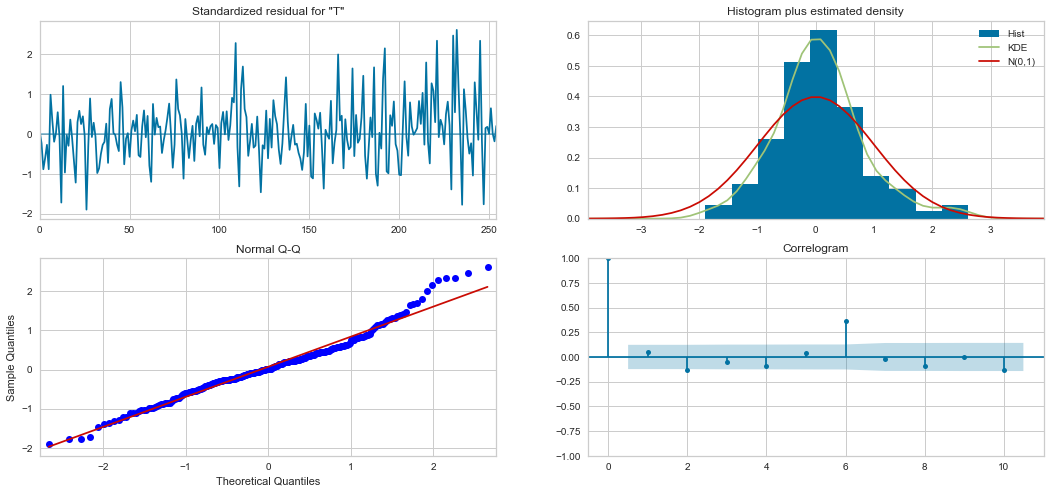

In [307]:
SARIMA_daily_sales_model.plot_diagnostics(figsize=(18, 8))
plt.show()

### Explanation
From the first graph you see the residuals are distributed above and bellow the zero with no visible pattern. From the histogram and Q-Q plot you see how the residuals seems to be normal distributed, they have zero mean. And from the last graph you see the residuals are uncorrelated.

In [308]:
start = len(train_daily_sales)
end = len(train_daily_sales)+len(test_daily_sales)-1
print(start,end)

271 304


In [309]:
SARIMA_daily_sales_predictions = SARIMA_daily_sales_model.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA')

In [311]:
SARIMA_daily_sales_predictions = pd.DataFrame(SARIMA_daily_sales_predictions,columns = ['SARIMA'])
SARIMA_daily_sales_predictions

SARIMA
271  32906.727137
272  30670.022426
273  29217.655802
274  33225.999190
275  31529.460243
276  35644.354728
277  29255.191805
278  32435.749699
279  30295.013618
280  28919.060595
281  32988.247180
282  31340.153728
283  35493.622219
284  29135.173279
285  32340.186726
286  30218.923016
287  28858.474581
288  32940.006464
289  31301.742772
290  35463.038065
291  29110.821099
292  32320.796663
293  30203.483966
294  28846.181466
295  32930.218253
296  31293.949054
297  35456.832433
298  29105.879956
299  32316.862352
300  30200.351329
301  28843.687150
302  32928.232191
303  31292.367682
304  35455.573288

In [312]:
SARIMA_daily_sales_predictions.reset_index(inplace=True,drop=True)
SARIMA_daily_sales_predictions = SARIMA_daily_sales_predictions.join(test_index)
SARIMA_daily_sales_predictions

SARIMA       date
0   32906.727137 2011-11-01
1   30670.022426 2011-11-02
2   29217.655802 2011-11-03
3   33225.999190 2011-11-04
4   31529.460243 2011-11-06
5   35644.354728 2011-11-07
6   29255.191805 2011-11-08
7   32435.749699 2011-11-09
8   30295.013618 2011-11-10
9   28919.060595 2011-11-11
10  32988.247180 2011-11-13
11  31340.153728 2011-11-14
12  35493.622219 2011-11-15
13  29135.173279 2011-11-16
14  32340.186726 2011-11-17
15  30218.923016 2011-11-18
16  28858.474581 2011-11-20
17  32940.006464 2011-11-21
18  31301.742772 2011-11-22
19  35463.038065 2011-11-23
20  29110.821099 2011-11-24
21  32320.796663 2011-11-25
22  30203.483966 2011-11-27
23  28846.181466 2011-11-28
24  32930.218253 2011-11-29
25  31293.949054 2011-11-30
26  35456.832433 2011-12-01
27  29105.879956 2011-12-02
28  32316.862352 2011-12-04
29  30200.351329 2011-12-05
30  28843.687150 2011-12-06
31  32928.232191 2011-12-07
32  31292.367682 2011-12-08
33  35455.573288 2011-12-09

In [313]:
#Sets index to the time_index
SARIMA_daily_sales_predictions.set_index('date', inplace=True)

In [316]:
SARIMA_daily_sales_predictions.index.name = None

In [317]:
fig = px.line(train_daily_sales, x = train_daily_sales.index, y = ['TotalPrice'], 
              color_discrete_map={
                 "TotalPrice": "#4285f5"
             })
fig2 = px.line(test_daily_sales, x = test_daily_sales.index, y = ['TotalPrice'],
              color_discrete_map={
                 "TotalPrice": "#35a953"
             })
fig3 = px.line(SARIMA_daily_sales_predictions, x = SARIMA_daily_sales_predictions.index, y = ['SARIMA'],
              color_discrete_map={
                 "SARIMA": "#fbbc05"
             })
fig4 = px.line(winters_daily_sales_predictions, x = winters_daily_sales_predictions.index, y = ['Winters_pred'],
              color_discrete_map={
                 "Winters_pred": "#ea4436"
             })

fig5 = go.Figure(data=fig.data + fig2.data+fig3.data+fig4.data)
fig5.show()

### Evaluation metrics

In [318]:
print(f'Mean Absolute Error = {mean_absolute_error(test_daily_sales,SARIMA_daily_sales_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_daily_sales,SARIMA_daily_sales_predictions)}')
print(f'Root Mean Squared Error = {mean_squared_error(test_daily_sales,SARIMA_daily_sales_predictions,squared=False)}')
print(f'Mean Absolute Percentage Error = {mape(test_daily_sales,SARIMA_daily_sales_predictions)}')

Mean Absolute Error = 13243.452955076089
Mean Squared Error = 233752966.16442108
Root Mean Squared Error = 15288.981855062197
Mean Absolute Percentage Error = 33.53


### SARIMA Second try using another grid search

In [319]:
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [320]:
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [321]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_daily_sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:6251.983882239337
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:5960.477021215456
ARIMA(0, 0, 0)x(0, 0, 2, 7) - AIC:5788.456207476995
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:5747.1458932790565
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:5476.40282962213
ARIMA(0, 0, 0)x(0, 1, 2, 7) - AIC:5331.22797198539
ARIMA(0, 0, 0)x(0, 2, 0, 7) - AIC:5865.8519230284255
ARIMA(0, 0, 0)x(0, 2, 1, 7) - AIC:5486.150681732744
ARIMA(0, 0, 0)x(0, 2, 2, 7) - AIC:5278.633318673028
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:5751.187629858512
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:5642.137939417444
ARIMA(0, 0, 0)x(1, 0, 2, 7) - AIC:5471.502583735422
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:5570.940515016661
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:5478.049943524001
ARIMA(0, 0, 0)x(1, 1, 2, 7) - AIC:5329.929375824776
ARIMA(0, 0, 0)x(1, 2, 0, 7) - AIC:5606.680509640983
ARIMA(0, 0, 0)x(1, 2, 1, 7) - AIC:5443.719862824261
ARIMA(0, 0, 0)x(1, 2, 2, 7) - AIC:5255.835684124253
ARIMA(0, 0, 0)x(2, 0, 0, 7) - AIC:5565.808973069512
ARIMA(0, 0, 

ARIMA(0, 1, 2)x(2, 1, 2, 7) - AIC:5294.470010791307
ARIMA(0, 1, 2)x(2, 2, 0, 7) - AIC:5439.890755928869
ARIMA(0, 1, 2)x(2, 2, 1, 7) - AIC:5409.700480483712
ARIMA(0, 1, 2)x(2, 2, 2, 7) - AIC:5340.391639900189
ARIMA(0, 2, 0)x(0, 0, 0, 7) - AIC:6080.837700635722
ARIMA(0, 2, 0)x(0, 0, 1, 7) - AIC:5915.609661576233
ARIMA(0, 2, 0)x(0, 0, 2, 7) - AIC:5757.9919634446815
ARIMA(0, 2, 0)x(0, 1, 0, 7) - AIC:6151.345848215929
ARIMA(0, 2, 0)x(0, 1, 1, 7) - AIC:5827.837427213075
ARIMA(0, 2, 0)x(0, 1, 2, 7) - AIC:5668.335415638401
ARIMA(0, 2, 0)x(0, 2, 0, 7) - AIC:6274.086793774774
ARIMA(0, 2, 0)x(0, 2, 1, 7) - AIC:5912.768637929921
ARIMA(0, 2, 0)x(0, 2, 2, 7) - AIC:5702.34388610554
ARIMA(0, 2, 0)x(1, 0, 0, 7) - AIC:5940.17556885517
ARIMA(0, 2, 0)x(1, 0, 1, 7) - AIC:5917.397019189266
ARIMA(0, 2, 0)x(1, 0, 2, 7) - AIC:5756.577477629982
ARIMA(0, 2, 0)x(1, 1, 0, 7) - AIC:5925.34428207921
ARIMA(0, 2, 0)x(1, 1, 1, 7) - AIC:5794.582743576411
ARIMA(0, 2, 0)x(1, 1, 2, 7) - AIC:5639.657627473071
ARIMA(0, 2, 0)

ARIMA(1, 0, 2)x(2, 0, 1, 7) - AIC:5428.119133626809
ARIMA(1, 0, 2)x(2, 0, 2, 7) - AIC:5385.679138633695
ARIMA(1, 0, 2)x(2, 1, 0, 7) - AIC:5369.232551613107
ARIMA(1, 0, 2)x(2, 1, 1, 7) - AIC:5347.552580994137
ARIMA(1, 0, 2)x(2, 1, 2, 7) - AIC:5305.061134811574
ARIMA(1, 0, 2)x(2, 2, 0, 7) - AIC:5415.697211788422
ARIMA(1, 0, 2)x(2, 2, 1, 7) - AIC:5382.078739687394
ARIMA(1, 0, 2)x(2, 2, 2, 7) - AIC:5335.252785521945
ARIMA(1, 1, 0)x(0, 0, 0, 7) - AIC:5787.33588660139
ARIMA(1, 1, 0)x(0, 0, 1, 7) - AIC:5639.590527653425
ARIMA(1, 1, 0)x(0, 0, 2, 7) - AIC:5479.700735625538
ARIMA(1, 1, 0)x(0, 1, 0, 7) - AIC:5842.0933336836515
ARIMA(1, 1, 0)x(0, 1, 1, 7) - AIC:5564.952694257404
ARIMA(1, 1, 0)x(0, 1, 2, 7) - AIC:5414.986317976178
ARIMA(1, 1, 0)x(0, 2, 0, 7) - AIC:5962.026908290185
ARIMA(1, 1, 0)x(0, 2, 1, 7) - AIC:5645.22468963859
ARIMA(1, 1, 0)x(0, 2, 2, 7) - AIC:5453.749773572641
ARIMA(1, 1, 0)x(1, 0, 0, 7) - AIC:5640.52346161991
ARIMA(1, 1, 0)x(1, 0, 1, 7) - AIC:5637.827128761388
ARIMA(1, 1, 0)

ARIMA(1, 2, 2)x(1, 2, 0, 7) - AIC:5657.298366103726
ARIMA(1, 2, 2)x(1, 2, 1, 7) - AIC:5566.798016669729
ARIMA(1, 2, 2)x(1, 2, 2, 7) - AIC:5397.658923522773
ARIMA(1, 2, 2)x(2, 0, 0, 7) - AIC:5409.092142874268
ARIMA(1, 2, 2)x(2, 0, 1, 7) - AIC:5411.057272667933
ARIMA(1, 2, 2)x(2, 0, 2, 7) - AIC:5369.477003649196
ARIMA(1, 2, 2)x(2, 1, 0, 7) - AIC:5418.737501975433
ARIMA(1, 2, 2)x(2, 1, 1, 7) - AIC:5387.114715302421
ARIMA(1, 2, 2)x(2, 1, 2, 7) - AIC:5342.741891873842
ARIMA(1, 2, 2)x(2, 2, 0, 7) - AIC:5472.878008042046
ARIMA(1, 2, 2)x(2, 2, 1, 7) - AIC:5449.067068932153
ARIMA(1, 2, 2)x(2, 2, 2, 7) - AIC:5397.972304174511
ARIMA(2, 0, 0)x(0, 0, 0, 7) - AIC:5781.457115765872
ARIMA(2, 0, 0)x(0, 0, 1, 7) - AIC:5656.0282767309445
ARIMA(2, 0, 0)x(0, 0, 2, 7) - AIC:5501.285360900827
ARIMA(2, 0, 0)x(0, 1, 0, 7) - AIC:5727.853685089318
ARIMA(2, 0, 0)x(0, 1, 1, 7) - AIC:5497.093816395489
ARIMA(2, 0, 0)x(0, 1, 2, 7) - AIC:5350.674818011055
ARIMA(2, 0, 0)x(0, 2, 0, 7) - AIC:5845.4009288557545
ARIMA(2, 0

ARIMA(2, 1, 2)x(1, 0, 2, 7) - AIC:5357.378549492854
ARIMA(2, 1, 2)x(1, 1, 0, 7) - AIC:5525.528652907504
ARIMA(2, 1, 2)x(1, 1, 1, 7) - AIC:5437.57543095307
ARIMA(2, 1, 2)x(1, 1, 2, 7) - AIC:5288.7287794845615
ARIMA(2, 1, 2)x(1, 2, 0, 7) - AIC:5581.241861932715
ARIMA(2, 1, 2)x(1, 2, 1, 7) - AIC:5497.7800601416
ARIMA(2, 1, 2)x(1, 2, 2, 7) - AIC:5330.132508776012
ARIMA(2, 1, 2)x(2, 0, 0, 7) - AIC:5385.594213998559
ARIMA(2, 1, 2)x(2, 0, 1, 7) - AIC:5378.474376474309
ARIMA(2, 1, 2)x(2, 0, 2, 7) - AIC:5359.361954264819
ARIMA(2, 1, 2)x(2, 1, 0, 7) - AIC:5338.602202841146
ARIMA(2, 1, 2)x(2, 1, 1, 7) - AIC:5305.711184200767
ARIMA(2, 1, 2)x(2, 1, 2, 7) - AIC:5286.409284041856
ARIMA(2, 1, 2)x(2, 2, 0, 7) - AIC:5388.227874559427
ARIMA(2, 1, 2)x(2, 2, 1, 7) - AIC:5356.273535211114
ARIMA(2, 1, 2)x(2, 2, 2, 7) - AIC:5330.361275814138
ARIMA(2, 2, 0)x(0, 0, 0, 7) - AIC:5872.138926603717
ARIMA(2, 2, 0)x(0, 0, 1, 7) - AIC:5744.988927886989
ARIMA(2, 2, 0)x(0, 0, 2, 7) - AIC:5586.0473571549655
ARIMA(2, 2, 0

### Explanation
According Peterson T. (2014) the AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The low AIC value the better. Our output suggest that SARIMAX(0, 0, 0)x(2, 2, 2, 7) with AIC value of 5247.42 is the best combination.

### Running the SARIMA model with the parameters

In [322]:
mod = sm.tsa.statespace.SARIMAX(train_daily_sales,
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
SARIMA_daily_sales_model_2 = mod.fit()
print(SARIMA_daily_sales_model_2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.0837      0.164     -0.510      0.610      -0.405       0.238
ar.S.L14      -0.1326      0.113     -1.179      0.239      -0.353       0.088
ma.S.L7       -1.4296      0.126    -11.339      0.000      -1.677      -1.183
ma.S.L14       0.5270      0.124      4.245      0.000       0.284       0.770
sigma2      1.784e+08    5.8e-11   3.08e+18      0.000    1.78e+08    1.78e+08


### Residual check
Once we have fitted the model to the data, it is necessary to check the residual plots to verify the validity of the model fit. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals that should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

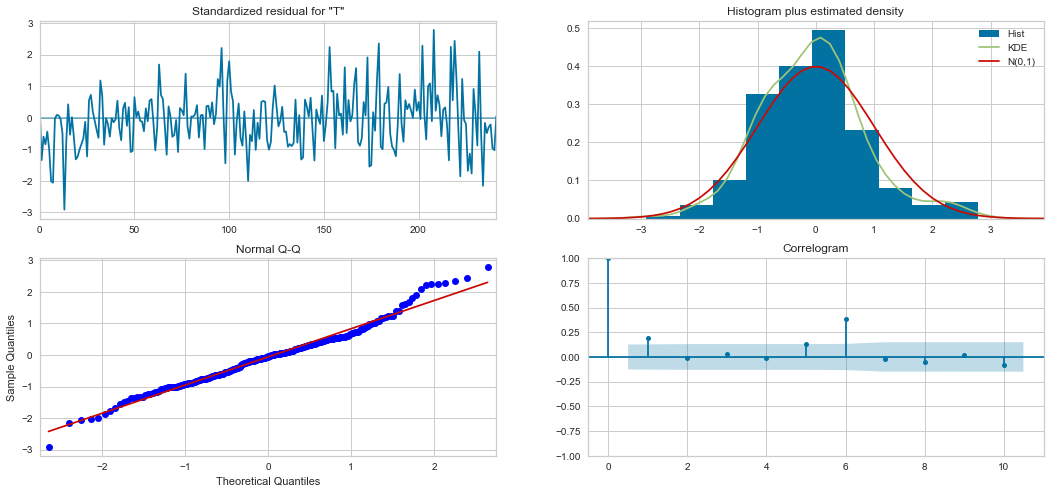

In [323]:
SARIMA_daily_sales_model_2.plot_diagnostics(figsize=(18, 8))
plt.show()

### Explanation
From the first graph you see the residuals are distributed above and bellow the zero with no visible pattern. From the histogram and Q-Q plot you see how the residuals seems to be normal distributed, they have zero mean. And from the last graph you see the residuals are uncorrelated.

In [324]:
SARIMA_daily_sales_predictions_2 = SARIMA_daily_sales_model_2.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA_2')

In [325]:
SARIMA_daily_sales_predictions_2 = pd.DataFrame(SARIMA_daily_sales_predictions_2,columns = ['SARIMA_2'])
SARIMA_daily_sales_predictions_2.reset_index(inplace=True,drop=True)
SARIMA_daily_sales_predictions_2 = SARIMA_daily_sales_predictions_2.join(test_index)
#Sets index to the time_index
SARIMA_daily_sales_predictions_2.set_index('date', inplace=True)
SARIMA_daily_sales_predictions_2.index.name = None
SARIMA_daily_sales_predictions_2

SARIMA_2
2011-11-01  36425.596616
2011-11-02  33566.378825
2011-11-03  33843.458529
2011-11-04  44715.473390
2011-11-06  40092.291681
2011-11-07  41978.613507
2011-11-08  31847.772045
2011-11-09  34600.975695
2011-11-10  35981.718316
2011-11-11  35692.942974
2011-11-13  45670.635268
2011-11-14  45642.424601
2011-11-15  42722.900783
2011-11-16  28852.487895
2011-11-17  34484.215242
2011-11-18  36712.673912
2011-11-20  36264.723767
2011-11-21  47525.948616
2011-11-22  47018.266872
2011-11-23  42580.253216
2011-11-24  28710.060618
2011-11-25  34821.704822
2011-11-27  37444.204605
2011-11-28  37315.328704
2011-11-29  49776.420482
2011-11-30  49026.554498
2011-12-01  43435.619199
2011-12-02  28742.442316
2011-12-04  34894.714403
2011-12-05  38399.055754
2011-12-06  38495.317947
2011-12-07  51874.466823
2011-12-08  51535.496519
2011-12-09  44325.118703

In [326]:
fig = px.line(train_daily_sales, x = train_daily_sales.index, y = ['TotalPrice'], 
              color_discrete_map={
                 "TotalPrice": "#4285f5"
             })
fig2 = px.line(test_daily_sales, x = test_daily_sales.index, y = ['TotalPrice'],
              color_discrete_map={
                 "TotalPrice": "#35a953"
             })
fig3 = px.line(SARIMA_daily_sales_predictions_2, x = SARIMA_daily_sales_predictions_2.index, y = ['SARIMA_2'],
              color_discrete_map={
                 "SARIMA_2": "#e462ef"
             })
fig4 = px.line(SARIMA_daily_sales_predictions, x = SARIMA_daily_sales_predictions.index, y = ['SARIMA'],
              color_discrete_map={
                 "SARIMA": "#fbbc05"
             })
fig5 = px.line(winters_daily_sales_predictions, x = winters_daily_sales_predictions.index, y = ['Winters_pred'],
              color_discrete_map={
                 "Winters_pred": "#ea4436"
             })

fig6 = go.Figure(data=fig.data + fig2.data+fig3.data+fig4.data+fig5.data)
fig6.show()

### Evaluation metrics

In [327]:
print(f'Mean Absolute Error = {mean_absolute_error(test_daily_sales,SARIMA_daily_sales_predictions_2)}')
print(f'Mean Squared Error = {mean_squared_error(test_daily_sales,SARIMA_daily_sales_predictions_2)}')
print(f'Root Mean Squared Error = {mean_squared_error(test_daily_sales,SARIMA_daily_sales_predictions_2,squared=False)}')
print(f'Mean Absolute Percentage Error = {mape(test_daily_sales,SARIMA_daily_sales_predictions_2)}')

Mean Absolute Error = 10328.94921321906
Mean Squared Error = 168344785.99468556
Root Mean Squared Error = 12974.774988210222
Mean Absolute Percentage Error = 30.73


### Forecast with prophet
The Prophet library expects as input a dataframe with one column containing the time information, and another column containing the metric that we wish to forecast. Prophet also imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column).

In [336]:
train_daily_sales_prophet = train_daily_sales.copy()

In [337]:
# A way to set the index as a column at the dataframe
train_daily_sales_prophet.reset_index(level=[0], inplace=True)
# Rename dateframe columns
train_daily_sales_prophet.rename(columns={'index':'ds','TotalPrice':'y'}, inplace=True)
train_daily_sales_prophet

ds         y
0   2010-12-01  41907.09
1   2010-12-02  43179.02
2   2010-12-03  23566.23
3   2010-12-05  31024.33
4   2010-12-06  28574.73
..         ...       ...
266 2011-10-26  29189.21
267 2011-10-27  40212.68
268 2011-10-28  32406.11
269 2011-10-30  34267.95
270 2011-10-31  31725.29

[271 rows x 2 columns]

In [340]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_daily_sales_model = Prophet(interval_width=0.95)

In [341]:
prophet_daily_sales_model.fit(train_daily_sales_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [344]:
future_dates = test_index
future_dates = pd.DataFrame(future_dates,columns = ['date'])
future_dates = future_dates.rename(columns={'date': 'ds'})

In [346]:
prophet_daily_sales_forecast = prophet_daily_sales_model.predict(future_dates)
prophet_daily_sales_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds          yhat    yhat_lower    yhat_upper
0 2011-11-01  36013.618711  20820.107849  52121.148687
1 2011-11-02  36056.330138  21117.028778  51106.382871
2 2011-11-03  41931.610464  25609.423534  57634.226651
3 2011-11-04  33054.431958  16668.781286  48565.362871
4 2011-11-06  25461.168933  10609.970691  40537.101416

In [347]:
prophet_daily_sales_forecast = prophet_daily_sales_forecast.rename(columns={'ds': 'date',
                                                                            'yhat':'prophet_prediction'})

In [348]:
# Set date_partition as the index of the dataframe
prophet_daily_sales_forecast.set_index('date', inplace=True)

In [349]:
fig = px.line(train_daily_sales, x = train_daily_sales.index, y = ['TotalPrice'], 
              color_discrete_map={
                 "TotalPrice": "#4285f5"
             })
fig2 = px.line(test_daily_sales, x = test_daily_sales.index, y = ['TotalPrice'],
              color_discrete_map={
                 "TotalPrice": "#35a953"
             })
fig3 = px.line(prophet_daily_sales_forecast, x = prophet_daily_sales_forecast.index, y = ['prophet_prediction'],
              color_discrete_map={
                 "prophet_prediction": "#1c1093"
             })
fig4 = px.line(SARIMA_daily_sales_predictions_2, x = SARIMA_daily_sales_predictions_2.index, y = ['SARIMA_2'],
              color_discrete_map={
                 "SARIMA_2": "#e462ef"
             })
fig5 = px.line(SARIMA_daily_sales_predictions, x = SARIMA_daily_sales_predictions.index, y = ['SARIMA'],
              color_discrete_map={
                 "SARIMA": "#fbbc05"
             })
fig6 = px.line(winters_daily_sales_predictions, x = winters_daily_sales_predictions.index, y = ['Winters_pred'],
              color_discrete_map={
                 "Winters_pred": "#ea4436"
             })

fig7 = go.Figure(data=fig.data + fig2.data + fig3.data + fig4.data + fig5.data + fig6.data)
fig7.show()

### Evaluation metrics

In [351]:
prophet_daily_sales_forecast = pd.DataFrame(prophet_daily_sales_forecast,columns = ['prophet_prediction'])

In [353]:
print(f'Mean Absolute Error = {mean_absolute_error(test_daily_sales,prophet_daily_sales_forecast)}')
print(f'Mean Squared Error = {mean_squared_error(test_daily_sales,prophet_daily_sales_forecast)}')
print(f'Root Mean Squared Error = {mean_squared_error(test_daily_sales,prophet_daily_sales_forecast,squared=False)}')
print(f'Mean Absolute Percentage Error = {mape(test_daily_sales,prophet_daily_sales_forecast)}')

Mean Absolute Error = 8697.768327170708
Mean Squared Error = 124013612.29322512
Root Mean Squared Error = 11136.139918895826
Mean Absolute Percentage Error = 23.42


**Conclusion**

It shows that the prophet forecast is the model with the least error. If we want to predict the number of transaction we could use the same model then, but fitting it with the corresponding time series.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

## Recommender system

#### Association Rule Learning (ARL)
Association Rule Learning is a rule-based machine learning technique that is used for finding patterns (relations, structures and so on) in datasets. By learning these patterns we will be able to offer some items to our customers. For offering, we will use the Apriori Algorithm.

#### Apriori Algorithm
In this learning technique, we use the Apriori Algorithm for extracting associations with targeted items. It has three following metrics:

1. **Support(X,Y) = Freq(X,Y)/N**
2. **Confidence(X,Y) = Freq(X,Y)/Freq(X)**
3. **Lift = Support(X,Y)/(Support(X)Support(Y))**

**Support** refers to the probability of observing X and Y together.

**Confidence** refers to the probability of observing Y when the X sold.

**Lift** refers to that when X is bought, the probability of buying Y increases by the **Lift** times.

### Let's apply this to our problem
We need to start from the data we prepared since the beginning of this exercise. In that dataset we dropped NA and we discard cancellation transactions

In [357]:
df_recommender = df1.copy()

### Let's create the Apriori Data Structure 
We need to set this structure for the Apriori Algorithm, rows represents transactions and columns the products. Here, we can represent the presence of a product in a transaction through a binary value. If the product is in the transaction, we assign 1, otherwise we assign 0.

In [360]:
def create_apriori_datastructure(dataframe, id=False):
    if id:
        grouped = germany_df.groupby(
            ['InvoiceNo', 'StockCode'], as_index=False).agg({'Quantity': 'sum'})
        apriori_datastructure = pd.pivot(data=grouped, index='InvoiceNo', columns='StockCode', values='Quantity').fillna(
            0).applymap(lambda x: 1 if x > 0 else 0)
        return apriori_datastructure
    else:
        grouped = germany_df.groupby(
            ['InvoiceNo', 'Description'], as_index=False).agg({'Quantity': 'sum'})
        apriori_datastructure = pd.pivot(data=grouped, index='InvoiceNo', columns='Description', values='Quantity').fillna(
            0).applymap(lambda x: 1 if x > 0 else 0)
        return apriori_datastructure

We are going to use German transactions for time and performance issues

In [361]:
germany_df = df_recommender[df_recommender['Country'] == 'Germany'] 
germany_df.head()

InvoiceNo StockCode                          Description  Quantity  \
1109    536527     22809              SET OF 6 T-LIGHTS SANTA         6   
1110    536527     84347  ROTATING SILVER ANGELS T-LIGHT HLDR         6   
1111    536527     84945   MULTI COLOUR SILVER T-LIGHT HOLDER        12   
1112    536527     22242        5 HOOK HANGER MAGIC TOADSTOOL        12   
1113    536527     22244           3 HOOK HANGER MAGIC GARDEN        12   

             InvoiceDate  UnitPrice  CustomerID  Country  TotalPrice  
1109 2010-12-01 13:04:00       2.95       12662  Germany        17.7  
1110 2010-12-01 13:04:00       2.55       12662  Germany        15.3  
1111 2010-12-01 13:04:00       0.85       12662  Germany        10.2  
1112 2010-12-01 13:04:00       1.65       12662  Germany        19.8  
1113 2010-12-01 13:04:00       1.95       12662  Germany        23.4

### Get Apriori Data Structure

In [362]:
germany_apriori_df = create_apriori_datastructure(germany_df,True)
germany_apriori_df.head() # Invoice-Product matrix (apriori data structure)

StockCode  10002  10125  10135  11001  15034  15036  15039  16008  16011  \
InvoiceNo                                                                  
536527         0      0      0      0      0      0      0      0      0   
536840         0      0      0      0      0      0      0      0      0   
536861         0      0      0      0      0      0      0      0      0   
536967         0      0      0      0      0      0      0      0      0   
536983         0      0      0      0      0      0      0      0      0   

StockCode  16014  ...  90161B  90161C  90161D  90201A  90201B  90201C  90201D  \
InvoiceNo         ...                                                           
536527         0  ...       0       0       0       0       0       0       0   
536840         0  ...       0       0       0       0       0       0       0   
536861         0  ...       0       0       0       0       0       0       0   
536967         0  ...       0       0       0       0       0       0       0   
536983         0  ...       0       0       0       0       0       0       0   

StockCode  90202D  M  POST  
InvoiceNo                   
536527          0  0     1  
536840          0  0     1  
536861          0  0     1  
536967          0  0     1  
536983          0  0     1  

[5 rows x 1664 columns]

### Learning Rules (Association Rule Learning)
We will use a function that will allows us to extract association rules. As input we will need a dataset with Apriori Data Structure. We will also use min_support as min probability that product will be sold together with each other. We'll apply the Apriori Algorith through apriori function. Finally, we'll extract the association rules through association_rules function.

In [363]:
def get_rules(apriori_df, min_support=0.01):
    frequent_itemsets = apriori(apriori_df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=min_support)
    return rules

In [364]:
germany_rules = get_rules(germany_apriori_df)
germany_rules.head()

antecedents consequents  antecedent support  consequent support   support  \
0      (POST)     (10125)            0.824444            0.013333  0.013333   
1     (10125)      (POST)            0.013333            0.824444  0.013333   
2     (15036)      (POST)            0.015556            0.824444  0.013333   
3      (POST)     (15036)            0.824444            0.015556  0.013333   
4     (16016)      (POST)            0.011111            0.824444  0.011111   

   confidence      lift  leverage  conviction  
0    0.016173  1.212938  0.002341    1.002886  
1    1.000000  1.212938  0.002341         inf  
2    0.857143  1.039661  0.000509    1.228889  
3    0.016173  1.039661  0.000509    1.000627  
4    1.000000  1.212938  0.001951         inf

### Rules' columns explanation
- **antecedents:** the first product (the product we assumed was sold first)
- **consequents:** the next product (the product we assumed is sold after the first product)
- **antecedent support:** probability of observing the first product
- **consequent support:** probability of observing the next product
- **support:** probability of observing the next product (consequent) and the first product (antecedent) together
- **conifdence:** probability of observing the next product when sold the first product
- **lift:** When the first product is sold, the probability of selling the next product increases by a factor of lift
- **leverage:** Similar to lift but tends to prior higher support values. We could avoid use it if we have lift
- **conviction:** probability of observing the antecedents without consequents

#### Utilities functions

In [365]:
# Get the product name based on a StockCode
def get_item_name(dataframe, stock_code):
    if type(stock_code) != list:
        product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
        return product_name
    else:
        product_names = [dataframe[dataframe["StockCode"] == product][["Description"]].values[0].tolist()[0] for product in stock_code]
        return product_names

In [369]:
get_item_name(germany_df,16016)

['LARGE CHINESE STYLE SCISSOR']

In [370]:
# Through this function we'll get the product that is in the shopping cart and recommended products related to it
def get_golden_shot(target_id,dataframe,rules):
    target_product = get_item_name(dataframe,target_id)[0]
    recomended_product_ids = recommend_products(rules, target_id)
    recomended_product_names = get_item_name(dataframe,recommend_products(rules, target_id))
    print(f'Target Product ID (which is in the cart): {target_id}\nProduct Name: {target_product}')
    print(f'Recommended Products: {recomended_product_ids}\nProduct Names: {recomended_product_names}')

In [372]:
# Function aimed to do a recommendation
def recommend_products(rules_df, product_id, rec_count=5):
    # rules_df -> the dataframe that we extracted rules
    # product_id -> the product id which is in the cart
    # rec_count -> count of recommended products
    sorted_rules = rules_df.sort_values('lift', ascending=False) # we are sorting the rules dataframe by using "lift" metric
    recommended_products = []  # creating an empty list for holding the recommended products

    for i, product in sorted_rules["antecedents"].items(): # loop on the first products (the products which are in the cart)
        for j in list(product):  # assign to a list for each product
            if j == product_id:  # if the list you return is equal to product_id, which means the product id in the cart
                # consequences column's first product id add to recommended products list 
                recommended_products.append(
                    list(sorted_rules.iloc[i]["consequents"]))
                
    recommended_products = list({item for item_list in recommended_products for item in item_list}) # get unique products

    return recommended_products[:rec_count] # return the recommended_products list by using rec_count limiter

### Test recommendations

In [374]:
# simulating some products like they are in cart
TARGET_PRODUCT_ID_1 = 22326
TARGET_PRODUCT_ID_2 = 20674
TARGET_PRODUCT_ID_3 = 15036

In [375]:
# What are the product names?
get_item_name(germany_df, [TARGET_PRODUCT_ID_1,TARGET_PRODUCT_ID_2, TARGET_PRODUCT_ID_3])

['ROUND SNACK BOXES SET OF4 WOODLAND ',
 'GREEN POLKADOT BOWL',
 'ASSORTED COLOURS SILK FAN']

### Let's see the recommendation function

In [376]:
get_golden_shot(TARGET_PRODUCT_ID_1,germany_df,germany_rules)

Target Product ID (which is in the cart): 22326
Product Name: ROUND SNACK BOXES SET OF4 WOODLAND 
Recommended Products: ['POST', 22534, 22551, 22553, 22554]
Product Names: ['POSTAGE', 'MAGIC DRAWING SLATE SPACEBOY ', 'PLASTERS IN TIN SPACEBOY', 'PLASTERS IN TIN SKULLS', 'PLASTERS IN TIN WOODLAND ANIMALS']


In [377]:
get_golden_shot(TARGET_PRODUCT_ID_2,germany_df,germany_rules)

Target Product ID (which is in the cart): 20674
Product Name: GREEN POLKADOT BOWL
Recommended Products: ['85099B', 'POST', 22037, 22423, 22554]
Product Names: ['JUMBO BAG RED RETROSPOT', 'POSTAGE', 'ROBOT BIRTHDAY CARD', 'REGENCY CAKESTAND 3 TIER', 'PLASTERS IN TIN WOODLAND ANIMALS']


In [378]:
get_golden_shot(TARGET_PRODUCT_ID_3,germany_df,germany_rules)

Target Product ID (which is in the cart): 15036
Product Name: ASSORTED COLOURS SILK FAN
Recommended Products: [21989, 21086]
Product Names: ['PACK OF 20 SKULL PAPER NAPKINS', 'SET/6 RED SPOTTY PAPER CUPS']
